# 增程式电动汽车模型

In [1]:
import pickle
import numpy as np
from scipy.interpolate import interp1d, interp2d
import math
import pprint
import scipy.io as scio
import matplotlib 
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def plot(data):
    x = np.arange(0, len(data), 1);    y = data;    plt.plot(x, y);    plt.show();

## 动力元件数据

In [3]:
# map图加载   pickle.dump(map, open('s_map-1.pkl', 'wb'))
map = pickle.load(open('s_map.pkl','rb'))  # s_mpa
Eng_eff = map['Eng_eff'] # 发动机MAP
Mot_eff = map['Mot_eff'] # 驱动电机MAP
Gen_eff = map['Gen_eff'] # 发电机MAP
# 转矩限制   转速 -> 转矩
Eng_t_max = map['Eng_t_max']   # 发动机最大转矩         
Mot_t_max = map['Mot_t_max']  # 驱动电机最大转矩
Mot_t_min = map['Mot_t_min']   # 驱动电机最小转矩
Gen_t_max = map['Gen_t_max']  # 发电机最大转矩
# 最佳燃油经济性线  功率 -> 转矩、转速    optimal fuel consumption line
find_te = map['find_te']      # 发动机转矩
find_we = map['find_we']   # 发动机转速
pprint.pprint(map)

{'Eng_eff': <scipy.interpolate.interpolate.interp2d object at 0x000002257E7A8400>,
 'Eng_t_max': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B75E8>,
 'Gen_eff': <scipy.interpolate.interpolate.interp2d object at 0x000002257E7A8BA8>,
 'Gen_t_max': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B7B88>,
 'Mot_eff': <scipy.interpolate.interpolate.interp2d object at 0x000002257E7A8898>,
 'Mot_t_max': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B77C8>,
 'Mot_t_min': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B79A8>,
 'R_chg': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B7228>,
 'R_dis': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B7408>,
 'V_oc': <scipy.interpolate.interpolate.interp1d object at 0x000002257E7B7048>,
 'find_te': <scipy.interpolate.interpolate.interp1d object at 0x000002254BDF9598>,
 'find_we': <scipy.interpolate.interpolate.interp1d object at 0x000002257E793A48>}


## 电池模型

In [4]:
# SOC对应的电压   V_oc = map['V_oc']
SOC_list = [0,0.00132660038355303,0.0574708841412090,0.107025590196296,0.156580329178506,0.206134478930137,0.255687515404994,0.305240257178054,0.354795683551491,0.404476817165514,0.454031523456938,0.503585181935343,0.553137334622058,0.602688668725870,0.652241410558679,0.701796476729142,0.751350724430672,0.800904841303918,0.850591981005177,0.900297369762374,0.950130539134393,0.999900000000000,1]
Batt_vol = [310.634972652632,310.634972652632,326.951157031579,329.458999831579,332.872264042105,335.715896273684,338.111014926316,340.582868147368,342.019372105263,343.171024421053,344.347621200000,345.680204905263,347.335128694737,349.668433263158,353.212415936842,356.773192105263,360.233421347368,363.941352947368,367.896574926316,372.075074905263,376.567860442105,381.712636042105,381.712636042105]
V_oc = interp1d(SOC_list, Batt_vol, kind = 'linear', fill_value = 'extrapolate')    
# 电池充电电阻   R_chg = map['R_chg']
Resistance_of_charge = [0.278441000000000,0.278441000000000,0.278441000000000,0.220686000000000,0.219190000000000,0.205348000000000,0.191300000000000,0.187277000000000,0.178095000000000,0.172985000000000,0.169769000000000,0.169487000000000,0.174937000000000,0.185496000000000,0.208445000000000,0.213703000000000,0.206749000000000,0.198442000000000,0.191939000000000,0.189976000000000,0.214378000000000,0.296465000000000,0.296465000000000]
R_chg = interp1d(SOC_list, Resistance_of_charge, kind = 'linear', fill_value = 'extrapolate')
# 电池放电电阻   R_dis = map['R_dis']
Resistance_of_discharge = [0.313944125557612,0.313944125557612,0.313944125557612,0.242065812972601,0.230789057570884,0.212882084646638,0.196703117398054,0.191970726117600,0.182268278911152,0.176602004689331,0.173003239603114,0.172594564949654,0.177777197273542,0.188139855710787,0.212047123247474,0.218402021824003,0.211830447697718,0.203822955457752,0.197028250778952,0.194459010902986,0.218377885152249,0.296468469580613,0.296468469580613]
R_dis = interp1d(SOC_list, Resistance_of_discharge, kind = 'linear', fill_value = 'extrapolate')

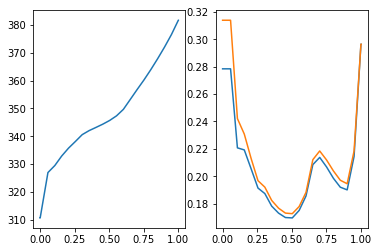

In [8]:
# 开路电压、充放电电阻、发动机功率点对应的转矩、发动机功率点对应的转速
plt.subplot(121);   plt.plot(SOC_list, Batt_vol); plt.subplot(122);   
plt.plot(SOC_list, Resistance_of_charge, SOC_list, Resistance_of_discharge);   plt.show()

## 驱动电机模型

In [9]:
mot_max_list = [];   mot_min_list = [];   iii = 0; 
# 驱动电机 (0,690) (0, +-326)
for iii in range(690):
    mot_max = Mot_t_max(iii); mot_max_list.append(mot_max);# 最大转矩[0,691]  [326.3, 161]
    mot_min = Mot_t_min(iii);  mot_min_list.append(mot_min); # 最小转矩[0,691] [-326.3,-161]

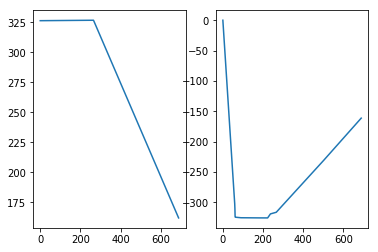

In [11]:
# 驱动电机最大转矩、驱动电机最小转矩
plt.subplot(121);   plt.plot(range(690), mot_max_list); plt.subplot(122);   
plt.plot(range(690), mot_min_list); plt.show()

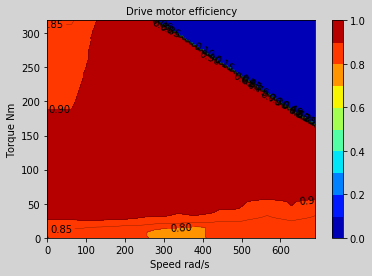

In [31]:
# 驱动电机效率map
mot_z_list = [];   mot_x_list = [];   mot_y_list = [];
for mot_x in range(690):      # 驱动电机转速
    for mot_y in range(320):  # 驱动电机转矩
        mot_z = Mot_eff(mot_x,  mot_y);   # 驱动电机效率
        mot_z_list.append(mot_z);   mot_x_list.append(mot_x);   mot_y_list.append(mot_y);
mot_x,   mot_y,   mot_z = mot_x_list,   mot_y_list,   mot_z_list;
mot_x = np.array(mot_x);   mot_x.shape = (690,320);   mot_x = np.mat(mot_x).T;
mot_y = np.array(mot_y);   mot_y.shape = (690,320);   mot_y = np.mat(mot_y).T;
mot_z = np.array(mot_z);   mot_z.shape = (690,320);   mot_z = np.mat(mot_z).T;
figure=plt.figure('contour',facecolor='lightgray');plt.title('Drive motor efficiency', fontsize=10);
plt.xlabel('Speed rad/s ', fontsize=10);plt.ylabel('Torque Nm', fontsize=10);   
cntr=plt.contour(mot_x, mot_y, mot_z, 20, colors='black',linewidths=0.2);
plt.clabel(cntr, fmt='%.2f', fontsize=10,manual=False);
plt.contourf(mot_x, mot_y, mot_z,10, cmap='jet',alpha=1);   plt.colorbar();   plt.show();

## 增程器模型

In [20]:
# 发动机、发电机最大转矩
eng_max_list = [];   gen_max_list = [];    iiii = 0;   
for iiii in range(370):
    eng_max = Eng_t_max(iiii);  eng_max_list.append(eng_max);# 转速[0,377]、转矩[240, 300]
    gen_max = Gen_t_max(iiii); gen_max_list.append(gen_max); # 转速[0,377]、转矩[200,377]

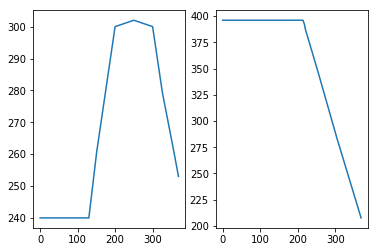

In [21]:
plt.subplot(121);  plt.plot(range(370), eng_max_list);  
plt.subplot(122); plt.plot(range(370), gen_max_list);   plt.show()

In [18]:
# 发动机最佳燃油经济性线  功率 -> 转矩、转速  
t_list = [];   w_list = [];   p_list = [];
for ii in range(85):
    p = ii * 1000;    t = find_te(p);   t_list.append(t);    w = find_we(p);   
    w_list.append(w);   p_list.append(p);

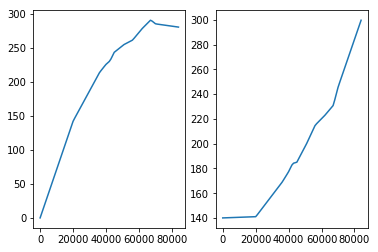

In [19]:
plt.subplot(121);  plt.plot(p_list, t_list);  plt.subplot(122); plt.plot(p_list, w_list);  plt.show()

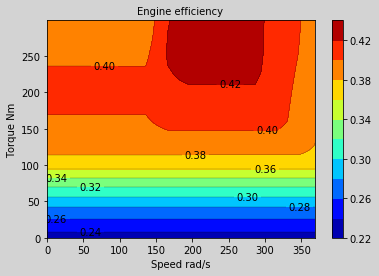

In [29]:
# 发动机效率map
eng_z_list = [];   eng_x_list = [];   eng_y_list = [];
for eng_x in range(370):      # 驱动电机转速
    for eng_y in range(300):  # 驱动电机转矩
        eng_z = Eng_eff(eng_x,  eng_y);   # 驱动电机效率
        eng_z_list.append(eng_z);   eng_x_list.append(eng_x);   eng_y_list.append(eng_y);
eng_x,   eng_y,   eng_z = eng_x_list,   eng_y_list,   eng_z_list;
eng_x = np.array(eng_x);   eng_x.shape = (370,300);   eng_x = np.mat(eng_x).T;
eng_y = np.array(eng_y);   eng_y.shape = (370,300);   eng_y = np.mat(eng_y).T;
eng_z = np.array(eng_z);   eng_z.shape = (370,300);   eng_z = np.mat(eng_z).T;
figure=plt.figure('contour',facecolor='lightgray');plt.title('Engine efficiency ', fontsize=10);
plt.xlabel('Speed rad/s', fontsize=10);plt.ylabel('Torque Nm', fontsize=10);   
cntr=plt.contour(eng_x, eng_y, eng_z, 10, colors='black',linewidths=0.2);
plt.clabel(cntr, fmt='%.2f', fontsize=10,manual=False);
plt.contourf(eng_x, eng_y, eng_z,10, cmap='jet',alpha=1);  plt.colorbar();   plt.show();

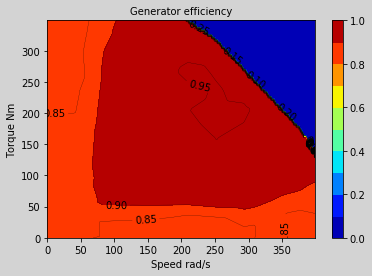

In [27]:
# 发电机燃油map
gen_z_list = [];   gen_x_list = [];   gen_y_list = [];
for gen_x in range(400):      # 驱动电机转速
    for gen_y in range(350):  # 驱动电机转矩
        gen_z = Gen_eff(gen_x,  gen_y);   # 驱动电机效率
        gen_z_list.append(gen_z);   gen_x_list.append(gen_x);   gen_y_list.append(gen_y);
gen_x,   gen_y,   gen_z = gen_x_list,   gen_y_list,   gen_z_list;
gen_x = np.array(gen_x);   gen_x.shape = (400,350);   gen_x = np.mat(gen_x).T;
gen_y = np.array(gen_y);   gen_y.shape = (400,350);   gen_y = np.mat(gen_y).T;
gen_z = np.array(gen_z);   gen_z.shape = (400,350);   gen_z = np.mat(gen_z).T;
figure=plt.figure('contour',facecolor='lightgray');plt.title('Generator efficiency', fontsize=10);
plt.xlabel('Speed rad/s', fontsize=10);plt.ylabel('Torque Nm', fontsize=10);   
cntr=plt.contour(gen_x, gen_y, gen_z, 20, colors='black',linewidths=0.2);
plt.clabel(cntr, fmt='%.2f', fontsize=10,manual=False);
plt.contourf(gen_x, gen_y, gen_z, 10, cmap='jet',alpha=1);   plt.colorbar();  
plt.show();

## 车速、转矩

In [12]:
data_path = 'Data_Standard Driving Cycles/Driving_cycle.mat' ;   data = scio.loadmat(data_path);
Velocity = data['Velocity2'];   Torque  = data['Torque2'];   data.keys();
car_spd_one = Velocity[:,1];     Torque = Torque[:,1];
Torque_max = np.max(Torque);     Torque_min =  np.min(Torque);
speed_max = np.max(car_spd_one);   total_milage = np.sum(car_spd_one) / 1000; 

最大车速: 29.89422438613241 总里程: 15.8649928964782 最大转矩: 2365.118367560885 最小转矩: -1971.6649075137802


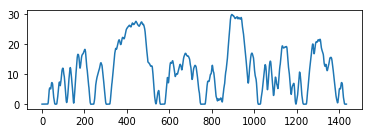

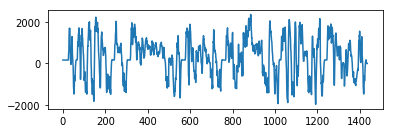

In [13]:
print ( '最大车速:', speed_max, '总里程:', total_milage,'最大转矩:', Torque_max, '最小转矩:', Torque_min)
plt.subplot(211); plot(car_spd_one); plt.subplot(212); plot(Torque);

## 车辆参数

In [14]:
PlatoonParameter = 'Data_Standard Driving Cycles/PlatoonParameter.mat'
PlatoonParameter = scio.loadmat(PlatoonParameter);   PlatoonParameter.keys();
Mass = PlatoonParameter['Mass'];   R  = PlatoonParameter['R'];

In [15]:
R_wheel = R[0]            # m, 车轮半径
mass = Mass[0]              # kg, 车重
G_f = 5.857                # 传动比
C_roll = 0.01              # 滚动阻力系数
rho = 1.2                  # kg/m^3, 空气密度
A_fr = 3.9                 # m^2, 迎风面积
C_d = 0.65                 # 风阻系数
gg = 9.8                   # m/s^2, 重力加速度
RPM_2_rads = 2*np.pi/60    # rpm to rad/s
Q_batt = 25 * 3600         # 电池容量

## 运行

In [16]:
T_axle = Torque[0]                    # 车轮转矩
car_speed = car_spd_one[0]     # 车速
W_axle = car_speed / R_wheel # 车轮转速
P_axle = T_axle * W_axle  # 车轮功率
soc = 0.5  # 电池SOC
P = 0   # 发动机工作点

In [17]:
# 驱动电机
W_mot = W_axle * G_f   # 驱动电机转速
T_mot = T_axle / G_f   # 驱动电机转矩
if T_axle > 0:
    T_mot = T_mot if T_mot < Mot_t_max(W_mot) else Mot_t_max(W_mot) # 驱动电机最大限制
else:
    T_mot = T_mot if T_mot > Mot_t_min(W_mot) else Mot_t_min(W_mot)  # 驱动电机最小限制
P_mot = W_mot * T_mot               # 驱动电机功率
eff_m = Mot_eff(W_mot, T_mot)   # 驱动电机效率
if eff_m < 0.80:
    eff_m = 0.85                    # 效率范围
P_mot = P_mot / eff_m if T_mot > 0 else P_mot * eff_m  # 驱动电机需求功率

In [18]:
# 增程器
if P_axle <= 0:
    P = 0                       # 制动时增程器停止
P = P if P <= 85000 else 85000                  # 最大功率
T_eng = find_te(P) if P >= 20093 else 0     # 发动机转矩、工作范围   20093-85000
W_eng = find_we(P) if P >= 20093 else 0  # 发动机转速、工作范围   20093-85000
T_eng = Eng_t_max(W_eng) if T_eng > Eng_t_max(W_eng) else T_eng   # 发动机最大范围限制
T_eng = 0 if T_eng < 0 else T_eng                                           # 发动机最小范围限制
# 发电机
W_gen, T_gen = W_eng, -T_eng
T_gen = T_gen if T_gen > -Gen_t_max(W_gen) else -Gen_t_max(W_gen) # 发电机最大范围限制
T_eng = T_eng if T_gen != -Gen_t_max(W_gen) else -T_gen                     # 发电机最小范围限制
eff_g = Gen_eff(W_gen, T_gen)     # 发电机效率
P_gen = T_gen * W_gen * eff_g    # 增程器输出功率 < 0

In [19]:
# 电池
P_batt = P_gen + P_mot
if P_batt>0:
    r = R_dis(soc)    # 放电电阻 
else:
    r = R_chg(soc)  # 充电电阻 
V_batt = V_oc(soc)             # 开路电压
e_batt = 1 if P_batt>0 else 0.98    # 电池效率
if V_batt**2 - 4*r*P_batt < 0:                   # 最大电流
    P_gen_reg = P_gen + P_batt - V_batt**2/(4*r)
    P_eng = P_gen_reg / eff_g
    W_eng = W_eng if W_eng != 0  else 1500*self.RPM_2_rads   # 发动机转速
    T_eng = P_eng / W_eng   # 发动机转矩 = 发动机功率 / 发动机转速
    W_gen = W_eng           # 发电机转速 = 发动机转速
    T_gen = T_eng           # 发电机转矩 = 发动机转矩

In [20]:
# 能量消耗
eff_e = Eng_eff(W_eng, T_eng)          # 发动机效率
P_eng = T_eng * W_eng                       # 发动机输出功率
P_eng_for_fuel = T_eng * W_eng / eff_e      # 汽油100%发出的功率，发动机功率 / 效率
m_fuel = P_eng_for_fuel / 42500000          # 发动机燃油消耗 g
v_fuel = m_fuel / 0.72                      # 发动机燃油消耗 L
price_fuel = v_fuel*6.5                     # 发动机燃油消耗 ￥
price_elec = P_batt / 0.8 / 1000 / 3600 * 0.97   # 电量消耗 ￥
RMB_cost = (price_fuel + price_elec)        # 能量总消耗 ￥

In [21]:
# SoC更新
if V_batt**2 - 4*r*P_batt + 1e-10 >= 0:
    I_batt = e_batt * ( V_batt - np.sqrt(V_batt**2 - 4*r*P_batt+1e-10))/(2*r)
else:
    I_batt = e_batt * V_batt /(2*r)
soc_ = - I_batt / (Q_batt) + soc
soc = soc_
if soc > 1:
    soc = 1.0

In [22]:
print("车轮: %.3f " % P_axle,"驱动电机: %.3f " % P_mot,"增程器: %.3f " % P_gen,"电流: %.3f " % I_batt,"电池功率: %.3f " % P_batt,"SOC_new: %.3f" % soc)

车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.500


In [27]:
P_list = [];   P_axle_list = [];   T_axle_list = [];   W_axle_list = [];   P_eng_list = [];   
T_eng_list = [];   W_eng_list = [];   eff_e_list = [];   P_gen_list = [];   T_gen_list = [];   
W_gen_list = [];   eff_g_list = [];   P_mot_list = [];   T_mot_list = [];   W_mot_list = [];   
eff_m_list = [];   P_batt_list = [];   price_fuel_list = [];   price_elec_list = [];   

In [29]:
for j in range(len(car_spd_one)):
    P = 30000
    
    car_speed = car_spd_one[j]
    car_speed = car_speed if car_speed > 0 else 0 
    T_axle = Torque[j]          # 车轮转矩
    W_axle = car_speed / R_wheel # 车轮转速
    P_axle = T_axle * W_axle  # 车轮功率
    
    # 驱动电机
    W_mot = W_axle * G_f   # 驱动电机转速
    T_mot = T_axle / G_f   # 驱动电机转矩
    if T_axle > 0:
        T_mot = T_mot if T_mot < Mot_t_max(W_mot) else Mot_t_max(W_mot)   # 驱动电机最大限制
    else:
        T_mot = T_mot if T_mot > Mot_t_min(W_mot) else Mot_t_min(W_mot)   # 驱动电机最小限制
    P_mot = W_mot * T_mot               # 驱动电机功率
    eff_m = Mot_eff(W_mot, T_mot)  # 驱动电机效率
    if eff_m < 0.80:
        eff_m = 0.85                    # 效率范围
    P_mot = P_mot / eff_m if T_mot > 0 else P_mot * eff_m  # 驱动电机需求功率
    
    # 增程器
    # 发动机  工作范围   20093-85000
    if P_axle <= 0:
        P = 0                       # 制动时增程器停止
    if soc >= 0.7:
        P = 0

    P = P if P <= 85000 else 85000  # 最大功率

    T_eng = find_te(P) if P >= 20093 else 0  # 发动机转矩、工作范围   20093-85000
    W_eng = find_we(P) if P >= 20093 else 0  # 发动机转速、工作范围   20093-85000

    T_eng = Eng_t_max(W_eng) if T_eng > Eng_t_max(W_eng) else T_eng   # 发动机最大范围限制
    T_eng = 0 if T_eng < 0 else T_eng                                           # 发动机最小范围限制
    # 发电机
    W_gen, T_gen = W_eng, -T_eng
    T_gen = T_gen if T_gen > -Gen_t_max(W_gen) else -Gen_t_max(W_gen) # 发电机最大范围限制
    T_eng = T_eng if T_gen != -Gen_t_max(W_gen) else -T_gen                # 发电机最小范围限制
    eff_g = Gen_eff(W_gen, T_gen)                                          # 发电机效率
    P_gen = T_gen * W_gen * eff_g                                               # 增程器输出功率 < 0
    
    # 电池
    P_batt = P_gen + P_mot
    # 充电和放电电阻    r = self.R_dis(self.soc) if P_batt>0 else self.R_chg(self.soc)
    if P_batt>0:
        r = R_dis(soc)
    else:
        r = R_chg(soc)
    V_batt = V_oc(soc)             # 开路电压
    e_batt = 1 if P_batt>0 else 0.98    # 电池效率
    # 最大电流   Imax = 460
    if V_batt**2 - 4*r*P_batt < 0:
        P_gen_reg = P_gen + P_batt - V_batt**2/(4*r)
        P_eng = P_gen_reg / eff_g
        W_eng = W_eng if W_eng != 0  else 1500*self.RPM_2_rads   # 发动机转速
        T_eng = P_eng / W_eng   # 发动机转矩 = 发动机功率 / 发动机转速
        W_gen = W_eng           # 发电机转速 = 发动机转速
        T_gen = T_eng           # 发电机转矩 = 发动机转矩
    
    # 能量消耗
    eff_e = Eng_eff(W_eng, T_eng)          # 发动机效率
    P_eng = T_eng * W_eng                       # 发动机输出功率
    P_eng_for_fuel = T_eng * W_eng / eff_e      # 汽油100%发出的功率，发动机功率 / 效率
    m_fuel = P_eng_for_fuel / 42500000          # 发动机燃油消耗 g
    v_fuel = m_fuel / 0.72                      # 发动机燃油消耗 L
    price_fuel = v_fuel*6.5                     # 发动机燃油消耗 ￥
    price_elec = P_batt / 0.8 / 1000 / 3600 * 0.97   # 电量消耗 ￥
    RMB_cost = (price_fuel + price_elec)        # 能量总消耗 ￥
    
    # SoC更新
    if V_batt**2 - 4*r*P_batt + 1e-10 >= 0:
        I_batt = e_batt * ( V_batt - np.sqrt(V_batt**2 - 4*r*P_batt+1e-10))/(2*r)
    else:
        I_batt = e_batt * V_batt /(2*r)
    soc_ = - I_batt / (Q_batt) + soc
    soc = soc_
    if soc > 1:
        soc = 1.0
    P_axle_list.append(P_axle);   T_axle_list.append(T_axle);   W_axle_list.append(W_axle);   
    P_eng_list.append(P_eng);   T_eng_list.append(T_eng);   W_eng_list.append(W_eng);   
    eff_e_list.append(eff_e);   P_gen_list.append(P_gen);   T_gen_list.append(T_gen);   
    W_gen_list.append(W_gen);   eff_g_list.append(eff_g);   P_mot_list.append(P_mot);   
    T_mot_list.append(T_mot);   W_mot_list.append(W_mot);   eff_m_list.append(eff_m);   
    P_batt_list.append(P_batt);   price_fuel_list.append(price_fuel);   price_elec_list.append(price_elec);   
    print("车轮: %.3f " % P_axle,"驱动电机: %.3f " % P_mot,"增程器: %.3f " % P_gen,"电流: %.3f " % I_batt,"电池功率: %.3f " % P_batt, "SOC_new: %.3f" % soc, "油钱: %.3f " % price_fuel,"电费: %.3f " % price_elec,"总花费: %.3f " % RMB_cost)

车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.705 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000 

车轮: 11306.877  驱动电机: 13021.715  增程器: 0.000  电流: 37.350  电池功率: 13021.715  SOC_new: 0.702 油钱: 0.000  电费: 0.004  总花费: 0.004 
车轮: 15724.906  驱动电机: 18239.985  增程器: 0.000  电流: 52.834  电池功率: 18239.985  SOC_new: 0.701 油钱: 0.000  电费: 0.006  总花费: 0.006 
车轮: 12761.097  驱动电机: 14193.485  增程器: 0.000  电流: 40.807  电池功率: 14193.485  SOC_new: 0.701 油钱: 0.000  电费: 0.005  总花费: 0.005 
车轮: 14719.043  驱动电机: 16353.662  增程器: 0.000  电流: 47.212  电池功率: 16353.662  SOC_new: 0.700 油钱: 0.000  电费: 0.006  总花费: 0.006 
车轮: 18888.263  驱动电机: 21143.331  增程器: 0.000  电流: 61.604  电池功率: 21143.331  SOC_new: 0.699 油钱: 0.000  电费: 0.007  总花费: 0.007 
车轮: 11156.180  驱动电机: 12022.349  增程器: -27491.225  电流: -41.460  电池功率: -15468.877  SOC_new: 0.700 油钱: 0.015  电费: -0.005  总花费: 0.010 
车轮: 8043.354  驱动电机: 8621.169  增程器: -27491.225  电流: -50.306  电池功率: -18870.057  SOC_new: 0.701 油钱: 0.015  电费: -0.006  总花费: 0.009 
车轮: -1622.560  驱动电机: -1402.622  增程器: 0.000  电流: -3.845  电池功率: -1402.622  SOC_new: 0.701 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -123

车轮: 12750.101  驱动电机: 13702.445  增程器: -27491.225  电流: -37.073  电池功率: -13788.780  SOC_new: 0.697 油钱: 0.015  电费: -0.005  总花费: 0.011 
车轮: -6422.313  驱动电机: -5668.097  增程器: 0.000  电流: -15.437  电池功率: -5668.097  SOC_new: 0.698 油钱: 0.000  电费: -0.002  总花费: -0.002 
车轮: -12431.561  驱动电机: -11591.520  增程器: 0.000  电流: -31.270  电池功率: -11591.520  SOC_new: 0.698 油钱: 0.000  电费: -0.004  总花费: -0.004 
车轮: -43211.677  驱动电机: -40789.570  增程器: 0.000  电流: -105.352  电池功率: -40789.570  SOC_new: 0.699 油钱: 0.000  电费: -0.014  总花费: -0.014 
车轮: -51775.615  驱动电机: -48608.618  增程器: 0.000  电流: -124.173  电池功率: -48608.618  SOC_new: 0.701 油钱: 0.000  电费: -0.016  总花费: -0.016 
车轮: -47637.584  驱动电机: -44643.983  增程器: 0.000  电流: -114.632  电池功率: -44643.983  SOC_new: 0.702 油钱: 0.000  电费: -0.015  总花费: -0.015 
车轮: -29968.224  驱动电机: -28295.393  增程器: 0.000  电流: -74.344  电池功率: -28295.393  SOC_new: 0.703 油钱: 0.000  电费: -0.010  总花费: -0.010 
车轮: -30749.696  驱动电机: -28968.531  增程器: 0.000  电流: -76.028  电池功率: -28968.531  SOC_new: 0.704 油钱: 0.000 

车轮: 0.101  驱动电机: 0.111  增程器: 0.000  电流: 0.000  电池功率: 0.111  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.168  驱动电机: 0.186  增程器: 0.000  电流: 0.001  电池功率: 0.186  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.152  驱动电机: 0.168  增程器: 0.000  电流: 0.000  电池功率: 0.168  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.110  驱动电机: 0.121  增程器: 0.000  电流: 0.000  电池功率: 0.121  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.069  驱动电机: 0.076  增程器: 0.000  电流: 0.000  电池功率: 0.076  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.037  驱动电机: 0.041  增程器: 0.000  电流: 0.000  电池功率: 0.041  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.020  驱动电机: 0.022  增程器: 0.000  电流: 0.000  电池功率: 0.022  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 10.731  驱动电机: 11.581  增程器: 0.000  电流: 0.032  电池功率: 11.581  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 321.879  驱动电机: 354.800  增程器: 0.000  电流: 0.994  电池功率: 354.800  SOC_new: 0.708 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 1487.4

车轮: 34253.126  驱动电机: 36316.633  增程器: -27491.225  电流: 25.308  电池功率: 8825.408  SOC_new: 0.665 油钱: 0.015  电费: 0.003  总花费: 0.018 
车轮: 39729.370  驱动电机: 42166.169  增程器: -27491.225  电流: 42.533  电池功率: 14674.944  SOC_new: 0.664 油钱: 0.015  电费: 0.005  总花费: 0.020 
车轮: 62670.977  驱动电机: 66590.080  增程器: -27491.225  电流: 118.961  电池功率: 39098.855  SOC_new: 0.663 油钱: 0.015  电费: 0.013  总花费: 0.028 
车轮: 59080.230  驱动电机: 62768.129  增程器: -27491.225  电流: 106.495  电池功率: 35276.903  SOC_new: 0.662 油钱: 0.015  电费: 0.012  总花费: 0.027 
车轮: 62166.041  驱动电机: 66049.283  增程器: -27491.225  电流: 117.235  电池功率: 38558.057  SOC_new: 0.660 油钱: 0.015  电费: 0.013  总花费: 0.028 
车轮: 59235.047  驱动电机: 62927.216  增程器: -27491.225  电流: 107.061  电池功率: 35435.991  SOC_new: 0.659 油钱: 0.015  电费: 0.012  总花费: 0.027 
车轮: 54715.838  驱动电机: 58120.435  增程器: -27491.225  电流: 91.649  电池功率: 30629.209  SOC_new: 0.658 油钱: 0.015  电费: 0.010  总花费: 0.026 
车轮: 59400.029  驱动电机: 63098.501  增程器: -27491.225  电流: 107.662  电池功率: 35607.276  SOC_new: 0.657 油钱: 0.015  电费:

车轮: 8936.298  驱动电机: 9572.134  增程器: -27491.225  电流: -48.277  电池功率: -17919.092  SOC_new: 0.656 油钱: 0.015  电费: -0.006  总花费: 0.009 
车轮: 8437.167  驱动电机: 9050.187  增程器: -27491.225  电流: -49.638  电池功率: -18441.038  SOC_new: 0.657 油钱: 0.015  电费: -0.006  总花费: 0.009 
车轮: 11496.392  驱动电机: 12251.577  增程器: -27491.225  电流: -41.219  电池功率: -15239.649  SOC_new: 0.657 油钱: 0.015  电费: -0.005  总花费: 0.010 
车轮: 6899.392  驱动电机: 7458.340  增程器: -27491.225  电流: -53.780  电池功率: -20032.886  SOC_new: 0.658 油钱: 0.015  电费: -0.007  总花费: 0.008 
车轮: 7542.499  驱动电机: 8124.929  增程器: -27491.225  电流: -52.037  电池功率: -19366.297  SOC_new: 0.658 油钱: 0.015  电费: -0.007  总花费: 0.009 
车轮: 1911.811  驱动电机: 2321.682  增程器: -27491.225  电流: -67.034  电池功率: -25169.543  SOC_new: 0.659 油钱: 0.015  电费: -0.008  总花费: 0.007 
车轮: -9706.069  驱动电机: -9080.981  增程器: 0.000  电流: -24.789  电池功率: -9080.981  SOC_new: 0.660 油钱: 0.000  电费: -0.003  总花费: -0.003 
车轮: -21022.279  驱动电机: -19667.967  增程器: 0.000  电流: -52.806  电池功率: -19667.967  SOC_new: 0.660 油钱: 0.000  电费

车轮: 33206.677  驱动电机: 37132.935  增程器: -27491.225  电流: 27.539  电池功率: 9641.709  SOC_new: 0.692 油钱: 0.015  电费: 0.003  总花费: 0.018 
车轮: 38327.327  驱动电机: 42686.755  增程器: -27491.225  电流: 43.848  电池功率: 15195.529  SOC_new: 0.692 油钱: 0.015  电费: 0.005  总花费: 0.020 
车轮: 43403.446  驱动电机: 48331.615  增程器: -27491.225  电流: 60.787  电池功率: 20840.390  SOC_new: 0.691 油钱: 0.015  电费: 0.007  总花费: 0.022 
车轮: 40730.306  驱动电机: 44239.059  增程器: -27491.225  电流: 48.478  电池功率: 16747.834  SOC_new: 0.690 油钱: 0.015  电费: 0.006  总花费: 0.021 
车轮: 40610.962  驱动电机: 43947.353  增程器: -27491.225  电流: 47.613  电池功率: 16456.128  SOC_new: 0.690 油钱: 0.015  电费: 0.006  总花费: 0.021 
车轮: 31953.189  驱动电机: 34106.168  增程器: -27491.225  电流: 18.801  电池功率: 6614.943  SOC_new: 0.690 油钱: 0.015  电费: 0.002  总花费: 0.017 
车轮: 28905.402  驱动电机: 30724.891  增程器: -27491.225  电流: 9.137  电池功率: 3233.665  SOC_new: 0.690 油钱: 0.015  电费: 0.001  总花费: 0.016 
车轮: 16520.624  驱动电机: 17545.432  增程器: -27491.225  电流: -26.945  电池功率: -9945.793  SOC_new: 0.690 油钱: 0.015  电费: -0.003

车轮: 20075.191  驱动电机: 21588.018  增程器: 0.000  电流: 62.884  电池功率: 21588.018  SOC_new: 0.704 油钱: 0.000  电费: 0.007  总花费: 0.007 
车轮: 34460.619  驱动电机: 37737.868  增程器: 0.000  电流: 113.605  电池功率: 37737.868  SOC_new: 0.703 油钱: 0.000  电费: 0.013  总花费: 0.013 
车轮: 31735.631  驱动电机: 34415.170  增程器: 0.000  电流: 102.913  电池功率: 34415.170  SOC_new: 0.702 油钱: 0.000  电费: 0.012  总花费: 0.012 
车轮: 28024.370  驱动电机: 30071.717  增程器: 0.000  电流: 89.149  电池功率: 30071.717  SOC_new: 0.701 油钱: 0.000  电费: 0.010  总花费: 0.010 
车轮: 22661.148  驱动电机: 24133.724  增程器: 0.000  电流: 70.715  电池功率: 24133.724  SOC_new: 0.700 油钱: 0.000  电费: 0.008  总花费: 0.008 
车轮: 16567.158  驱动电机: 17573.884  增程器: 0.000  电流: 50.855  电池功率: 17573.884  SOC_new: 0.700 油钱: 0.000  电费: 0.006  总花费: 0.006 
车轮: 15485.446  驱动电机: 16440.070  增程器: -27491.225  电流: -29.825  电池功率: -11051.156  SOC_new: 0.700 油钱: 0.015  电费: -0.004  总花费: 0.011 
车轮: 17551.909  驱动电机: 18613.724  增程器: 0.000  电流: 53.973  电池功率: 18613.724  SOC_new: 0.699 油钱: 0.000  电费: 0.006  总花费: 0.006 
车轮: 16011.907 

车轮: -4698.628  驱动电机: -4111.743  增程器: 0.000  电流: -11.210  电池功率: -4111.743  SOC_new: 0.705 油钱: 0.000  电费: -0.001  总花费: -0.001 
车轮: -572.091  驱动电机: -505.239  增程器: 0.000  电流: -1.386  电池功率: -505.239  SOC_new: 0.705 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -1202.782  驱动电机: -1067.190  增程器: 0.000  电流: -2.924  电池功率: -1067.190  SOC_new: 0.705 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -1466.984  驱动电机: -1288.335  增程器: 0.000  电流: -3.529  电池功率: -1288.335  SOC_new: 0.706 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -1713.518  驱动电机: -1481.115  增程器: 0.000  电流: -4.055  电池功率: -1481.115  SOC_new: 0.706 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -652.206  驱动电机: -567.680  增程器: 0.000  电流: -1.557  电池功率: -567.680  SOC_new: 0.706 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: -344.703  驱动电机: -299.595  增程器: 0.000  电流: -0.822  电池功率: -299.595  SOC_new: 0.706 油钱: 0.000  电费: -0.000  总花费: -0.000 
车轮: 1117.133  驱动电机: 1206.166  增程器: 0.000  电流: 3.385  电池功率: 1206.166  SOC_new: 0.706 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 2608.715  驱动电机: 28

车轮: 27879.055  驱动电机: 29871.558  增程器: -27491.225  电流: 6.799  电池功率: 2380.333  SOC_new: 0.628 油钱: 0.015  电费: 0.001  总花费: 0.016 
车轮: 23978.902  驱动电机: 25571.361  增程器: -27491.225  电流: -5.337  电池功率: -1919.864  SOC_new: 0.628 油钱: 0.015  电费: -0.001  总花费: 0.015 
车轮: 24952.058  驱动电机: 26640.234  增程器: -27491.225  电流: -2.370  电池功率: -850.991  SOC_new: 0.628 油钱: 0.015  电费: -0.000  总花费: 0.015 
车轮: 41653.563  驱动电机: 44169.813  增程器: -27491.225  电流: 48.812  电池功率: 16678.587  SOC_new: 0.627 油钱: 0.015  电费: 0.006  总花费: 0.021 
车轮: 56661.296  驱动电机: 60190.314  增程器: -27491.225  电流: 98.577  电池功率: 32699.088  SOC_new: 0.626 油钱: 0.015  电费: 0.011  总花费: 0.026 
车轮: 68885.239  驱动电机: 73171.412  增程器: -27491.225  电流: 141.358  电池功率: 45680.186  SOC_new: 0.625 油钱: 0.015  电费: 0.015  总花费: 0.031 
车轮: 66451.420  驱动电机: 70579.593  增程器: -27491.225  电流: 132.628  电池功率: 43088.367  SOC_new: 0.623 油钱: 0.015  电费: 0.015  总花费: 0.030 
车轮: 46857.158  驱动电机: 49653.886  增程器: -27491.225  电流: 65.540  电池功率: 22162.661  SOC_new: 0.622 油钱: 0.015  电费: 0.

车轮: -2009.316  驱动电机: -1735.944  增程器: 0.000  电流: -4.814  电池功率: -1735.944  SOC_new: 0.641 油钱: 0.000  电费: -0.001  总花费: -0.001 
车轮: -7734.635  驱动电机: -7244.106  增程器: 0.000  电流: -19.911  电池功率: -7244.106  SOC_new: 0.641 油钱: 0.000  电费: -0.002  总花费: -0.002 
车轮: -13440.106  驱动电机: -12455.884  增程器: 0.000  电流: -33.956  电池功率: -12455.884  SOC_new: 0.642 油钱: 0.000  电费: -0.004  总花费: -0.004 
车轮: -16585.993  驱动电机: -15264.550  增程器: 0.000  电流: -41.430  电池功率: -15264.550  SOC_new: 0.642 油钱: 0.000  电费: -0.005  总花费: -0.005 
车轮: -20909.462  驱动电机: -18766.669  增程器: 0.000  电流: -50.660  电池功率: -18766.669  SOC_new: 0.643 油钱: 0.000  电费: -0.006  总花费: -0.006 
车轮: -22490.881  驱动电机: -19303.048  增程器: 0.000  电流: -52.059  电池功率: -19303.048  SOC_new: 0.643 油钱: 0.000  电费: -0.007  总花费: -0.007 
车轮: -20915.023  驱动电机: -17236.103  增程器: 0.000  电流: -46.623  电池功率: -17236.103  SOC_new: 0.644 油钱: 0.000  电费: -0.006  总花费: -0.006 
车轮: -16691.350  驱动电机: -11091.108  增程器: 0.000  电流: -30.282  电池功率: -11091.108  SOC_new: 0.644 油钱: 0.000  电费: -0.0

车轮: 39872.506  驱动电机: 42596.174  增程器: -27491.225  电流: 43.786  电池功率: 15104.948  SOC_new: 0.667 油钱: 0.015  电费: 0.005  总花费: 0.020 
车轮: 55524.917  驱动电机: 59861.844  增程器: -27491.225  电流: 97.052  电池功率: 32370.618  SOC_new: 0.666 油钱: 0.015  电费: 0.011  总花费: 0.026 
车轮: 57432.393  驱动电机: 61709.090  增程器: -27491.225  电流: 103.003  电池功率: 34217.864  SOC_new: 0.665 油钱: 0.015  电费: 0.012  总花费: 0.027 
车轮: 57351.117  驱动电机: 61313.012  增程器: -27491.225  电流: 101.750  电池功率: 33821.786  SOC_new: 0.664 油钱: 0.015  电费: 0.011  总花费: 0.027 
车轮: 70708.799  驱动电机: 76000.936  增程器: -27491.225  电流: 150.708  电池功率: 48509.710  SOC_new: 0.662 油钱: 0.015  电费: 0.016  总花费: 0.032 
车轮: 61225.482  驱动电机: 65199.622  增程器: -27491.225  电流: 114.430  电池功率: 37708.396  SOC_new: 0.661 油钱: 0.015  电费: 0.013  总花费: 0.028 
车轮: 55614.468  驱动电机: 59029.867  增程器: -27491.225  电流: 94.510  电池功率: 31538.641  SOC_new: 0.660 油钱: 0.015  电费: 0.011  总花费: 0.026 
车轮: 39116.389  驱动电机: 41541.194  增程器: -27491.225  电流: 40.712  电池功率: 14049.968  SOC_new: 0.660 油钱: 0.015  电费:

车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.000  驱动电机: 0.000  增程器: 0.000  电流: -0.000  电池功率: 0.000  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.090  驱动电机: 0.099  增程器: 0.000  电流: 0.000  电池功率: 0.099  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.123  驱动电机: 0.135  增程器: 0.000  电流: 0.000  电池功率: 0.135  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.105  驱动电机: 0.116  增程器: 0.000  电流: 0.000  电池功率: 0.116  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 0.099  驱动电机: 0.108  增程器: 0.000  电流: 0.000  电池功率: 0.108  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 45.634  驱动电机: 49.472  增程器: 0.000  电流: 0.139  电池功率: 49.472  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 700.624  驱动电机: 776.946  增程器: 0.000  电流: 2.181  电池功率: 776.946  SOC_new: 0.701 油钱: 0.000  电费: 0.000  总花费: 0.000 
车轮: 283

车轮: 18009.340  驱动电机: 19123.351  增程器: -27491.225  电流: -22.683  电池功率: -8367.875  SOC_new: 0.699 油钱: 0.015  电费: -0.003  总花费: 0.012 
车轮: 11858.852  驱动电机: 12683.066  增程器: -27491.225  电流: -39.730  电池功率: -14808.160  SOC_new: 0.700 油钱: 0.015  电费: -0.005  总花费: 0.010 
车轮: 14537.770  驱动电机: 15472.560  增程器: -27491.225  电流: -32.385  电池功率: -12018.665  SOC_new: 0.700 油钱: 0.015  电费: -0.004  总花费: 0.011 
车轮: 12213.385  驱动电机: 13053.961  增程器: 0.000  电流: 37.458  电池功率: 13053.961  SOC_new: 0.700 油钱: 0.000  电费: 0.004  总花费: 0.004 
车轮: 11149.852  驱动电机: 11952.871  增程器: -27491.225  电流: -41.639  电池功率: -15538.354  SOC_new: 0.700 油钱: 0.015  电费: -0.005  总花费: 0.010 
车轮: 3999.111  驱动电机: 4646.597  增程器: 0.000  电流: 13.133  电池功率: 4646.597  SOC_new: 0.700 油钱: 0.000  电费: 0.002  总花费: 0.002 
车轮: 1681.507  驱动电机: 2069.779  增程器: 0.000  电流: 5.824  电池功率: 2069.779  SOC_new: 0.700 油钱: 0.000  电费: 0.001  总花费: 0.001 
车轮: -7964.112  驱动电机: -7320.386  增程器: 0.000  电流: -19.873  电池功率: -7320.386  SOC_new: 0.700 油钱: 0.000  电费: -0.002  总花费: -0.00

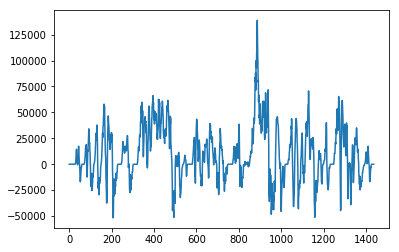

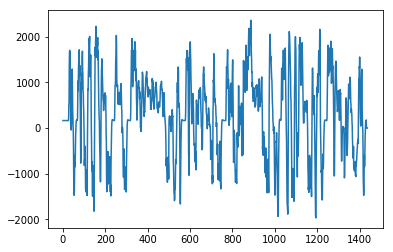

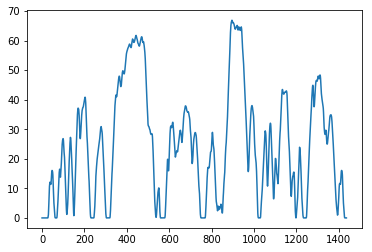

In [31]:
plot(P_axle_list);   plot(T_axle_list);   plot(W_axle_list);   # 车轮：功率、转矩、转速

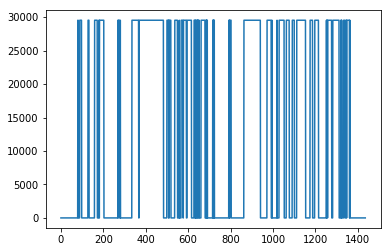

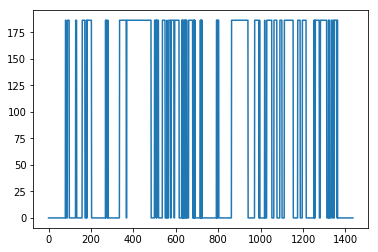

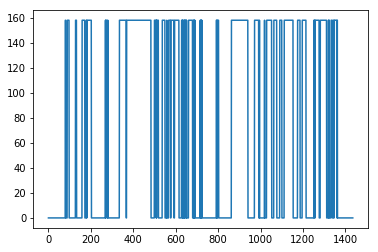

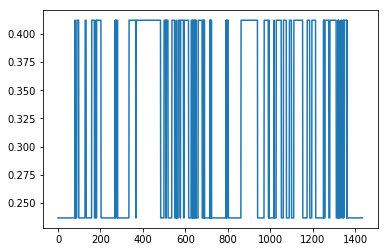

In [32]:
plot(P_eng_list);   plot(T_eng_list);   plot(W_eng_list);   plot(eff_e_list);   

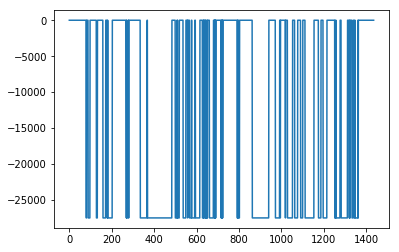

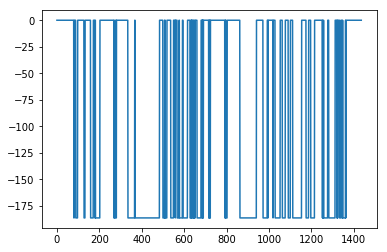

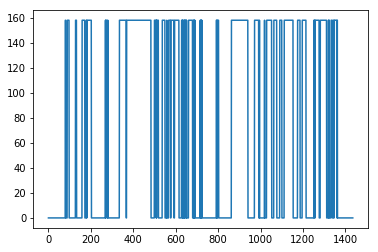

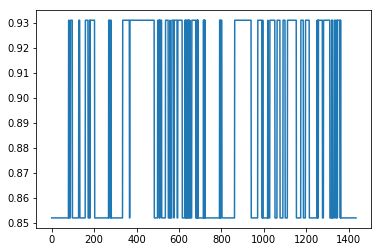

In [33]:
plot(P_gen_list);   plot(T_gen_list);   plot(W_gen_list);   plot(eff_g_list);   

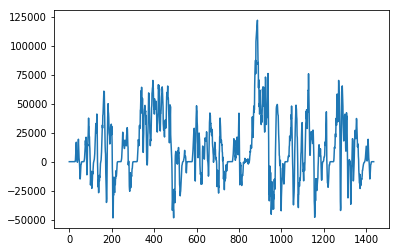

B:\Anaconda\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


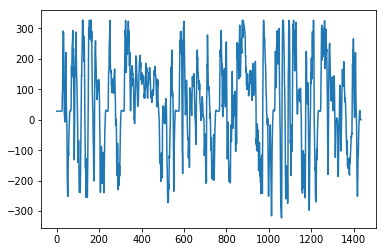

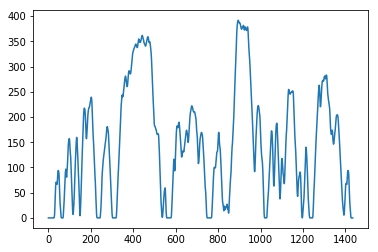

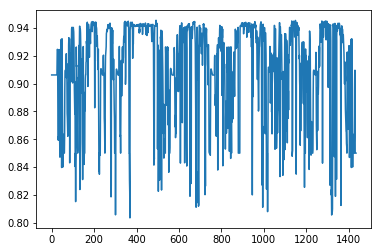

In [34]:
plot(P_mot_list);   plot(T_mot_list);   plot(W_mot_list);   plot(eff_m_list);  

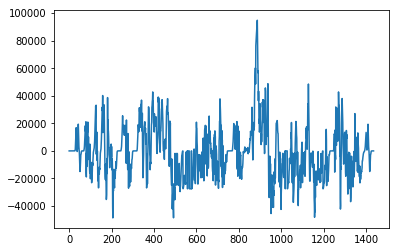

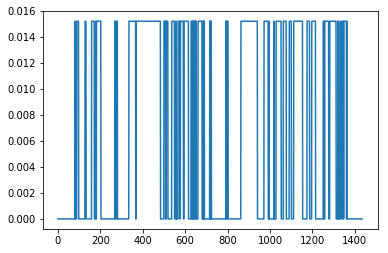

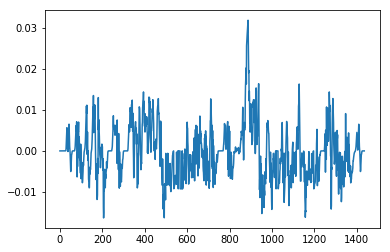

In [35]:
plot(P_batt_list);   plot(price_fuel_list);   plot(price_elec_list);  